In [18]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [19]:
files = []
path = Path('Water management research papers')

for file in path.rglob("*"):
  if file.is_file():
    files.append({
      "path": str(file),
      "project name": file.relative_to(path).parts[0],
      "extension": file.suffix.lower(),
      "size_bytes": file.stat().st_size,
      "size_mb": file.stat().st_size / (1024 * 1024),
      "folder_depth": len(file.relative_to(path).parents)
    })
    

In [20]:
files_df = pd.DataFrame(files)
files_df

,path,project name,extension,size_bytes,size_mb,folder_depth
0,Water management research papers\Inventory of ...,Inventory of projects.xlsx,.xlsx,373508,0.356205,1
1,Water management research papers\AquaSPICE\Rep...,AquaSPICE,.docx,8749643,8.344310,2
2,Water management research papers\DeltaDrip\202...,DeltaDrip,.pdf,3998227,3.813006,2
3,Water management research papers\DeltaDrip\del...,DeltaDrip,.pdf,1306540,1.246014,2
4,Water management research papers\E4Water\Econo...,E4Water,.pdf,397007,0.378615,2
...,...,...,...,...,...,...
118,Water management research papers\Waterhouderij...,Waterhouderij,.png,1170115,1.115909,3
119,Water management research papers\Waterhouderij...,Waterhouderij,.png,1285067,1.225535,3
120,Water management research papers\Waterhouderij...,Waterhouderij,.png,287821,0.274487,3
121,Water management research papers\Waterhouderij...,Waterhouderij,.png,693569,0.661439,3


extension
.pdf     48
.png     48
.docx    12
.jpg      7
.jpeg     4
.xlsx     1
.txt      1
.doc      1
.pptx     1
Name: count, dtype: int64


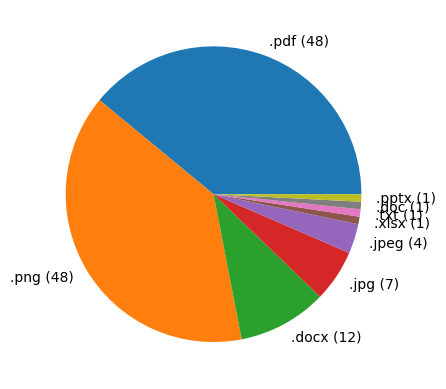

In [21]:
files_valeucounts = files_df['extension'].value_counts()
print(files_valeucounts)
plt.pie(files_valeucounts, labels=[f"{extension} ({count})" for extension, count in zip(files_valeucounts.index, files_valeucounts.values)])
plt.show()

In [22]:
text_documents = files_df[files_df.extension.isin(['.pdf', '.docx', '.doc', '.txt', '.pptx', '.xlsx'])]
images = files_df[files_df.extension.isin(['.png', '.jpg', '.jpeg'])]


# to make sure i have everything, this should be equal to 126 (or just same length as dataframe)
print(len(text_documents) + len (images), files_df.shape[0])

123 123


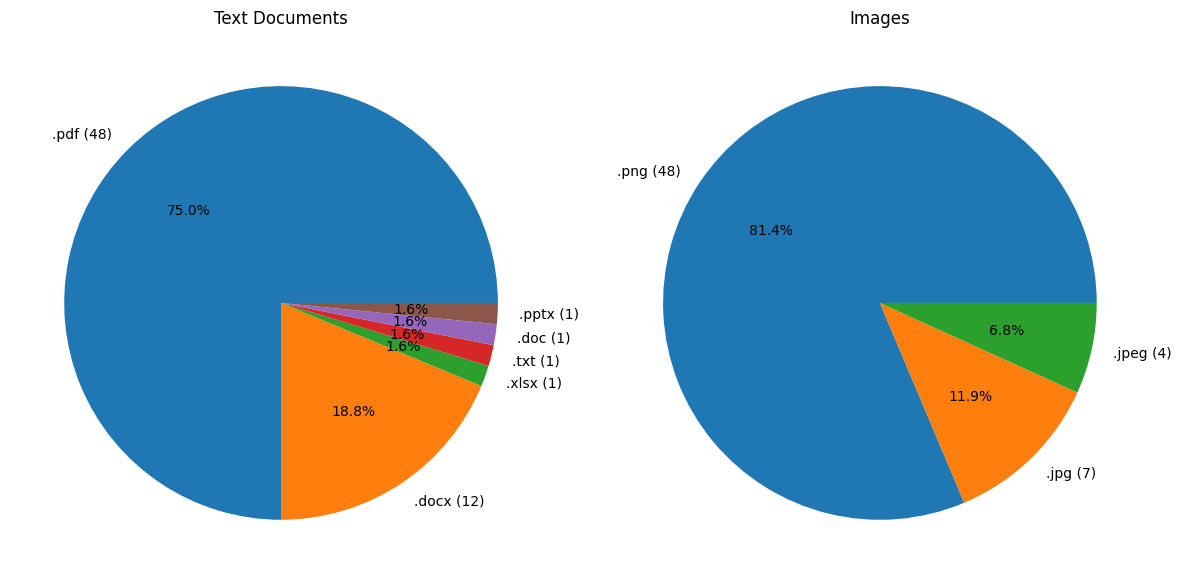

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
text_valuecounts = text_documents['extension'].value_counts()
axes[0].pie(text_valuecounts, labels=[f"{extension} ({count})" for extension, count in zip(text_valuecounts.index, text_valuecounts.values)], autopct='%1.1f%%')
axes[0].set_title("Text Documents")

image_valuecounts = images['extension'].value_counts()
axes[1].pie(image_valuecounts, labels=[f"{extension} ({count})" for extension, count in zip(image_valuecounts.index, image_valuecounts.values)], autopct='%1.1f%%')
axes[1].set_title("Images")

plt.tight_layout()
plt.show()

## Text analysis

In [24]:
# i generally don't like installing it here, but its easier to run the code for others that way :|
%pip install pypdf
%pip install python-docx

import pypdf
from docx import Document

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
complete_file_df = files_df.copy()
pdf_files = []

# maybe not the best way to determine language, but it seems to work perfectly
most_occuring_english_words = ["the", "be", "to", "and"]
most_occuring_dutch_words = ["de", "het", "of", "een"]

complete_file_df['num_pages'] = None
complete_file_df['word_count'] = None

for i, document in complete_file_df.iterrows():
  if document['extension'] == '.pdf':
    reader_object = pypdf.PdfReader(document['path'])

    language_text = ""
    for page in reader_object.pages[:10]:
      if page_text := page.extract_text():
        language_text += page_text
    
    english_score = 0
    dutch_score = 0
    for word in language_text.split():
      if word.lower() in most_occuring_english_words:
        english_score += 1
      elif word.lower() in most_occuring_dutch_words:
        dutch_score += 1
    
    complete_file_df.at[i, 'language'] = 'english' if english_score > dutch_score else 'dutch' if dutch_score > english_score else 'unknown'


    # since if you use ['column_name'].iloc[index], you get FutureWarning: ChainedAssignmentError
    # its the reason why i use .at[index, 'column_name'] instead
    complete_file_df.at[i, 'num_pages'] = len(reader_object.pages)
    complete_file_df.at[i, 'word_count'] = sum(len(text.split()) for page in reader_object.pages if (text := page.extract_text()))

  elif document['extension'] == '.docx':
    document = Document(document['path'])
    paragraphs = [paragraph.text for paragraph in document.paragraphs if paragraph.text]

    complete_file_df.at[i, 'num_pages'] = sum(paragraph.contains_page_break for paragraph in document.paragraphs) + 1
    complete_file_df.at[i, 'word_count'] = word_count = sum(len(paragraph.split()) for paragraph in paragraphs)
  
  elif document['extension'] == 'doc':
    # yes, this isn't pretty or scalable, but to install another dependency just
    # to read through the single doc file we have, isn't worth it in my opinion. That's
    # why this is done manually
    complete_file_df.at[i, 'num_pages'] = 2
    complete_file_df.at[i, 'word_count'] = 367

  elif document['extension'] == '.pptx':
    complete_file_df.at[i, 'num_pages'] = 1
    complete_file_df.at[i, 'word_count'] = 2

Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 32 0 (offset 0)
Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 75 0 (offset 0)


In [28]:
complete_file_df['text_density'] = complete_file_df['word_count'] / complete_file_df['num_pages']

In [33]:
complete_file_df['language'].value_counts()

language
dutch      31
english    17
Name: count, dtype: int64

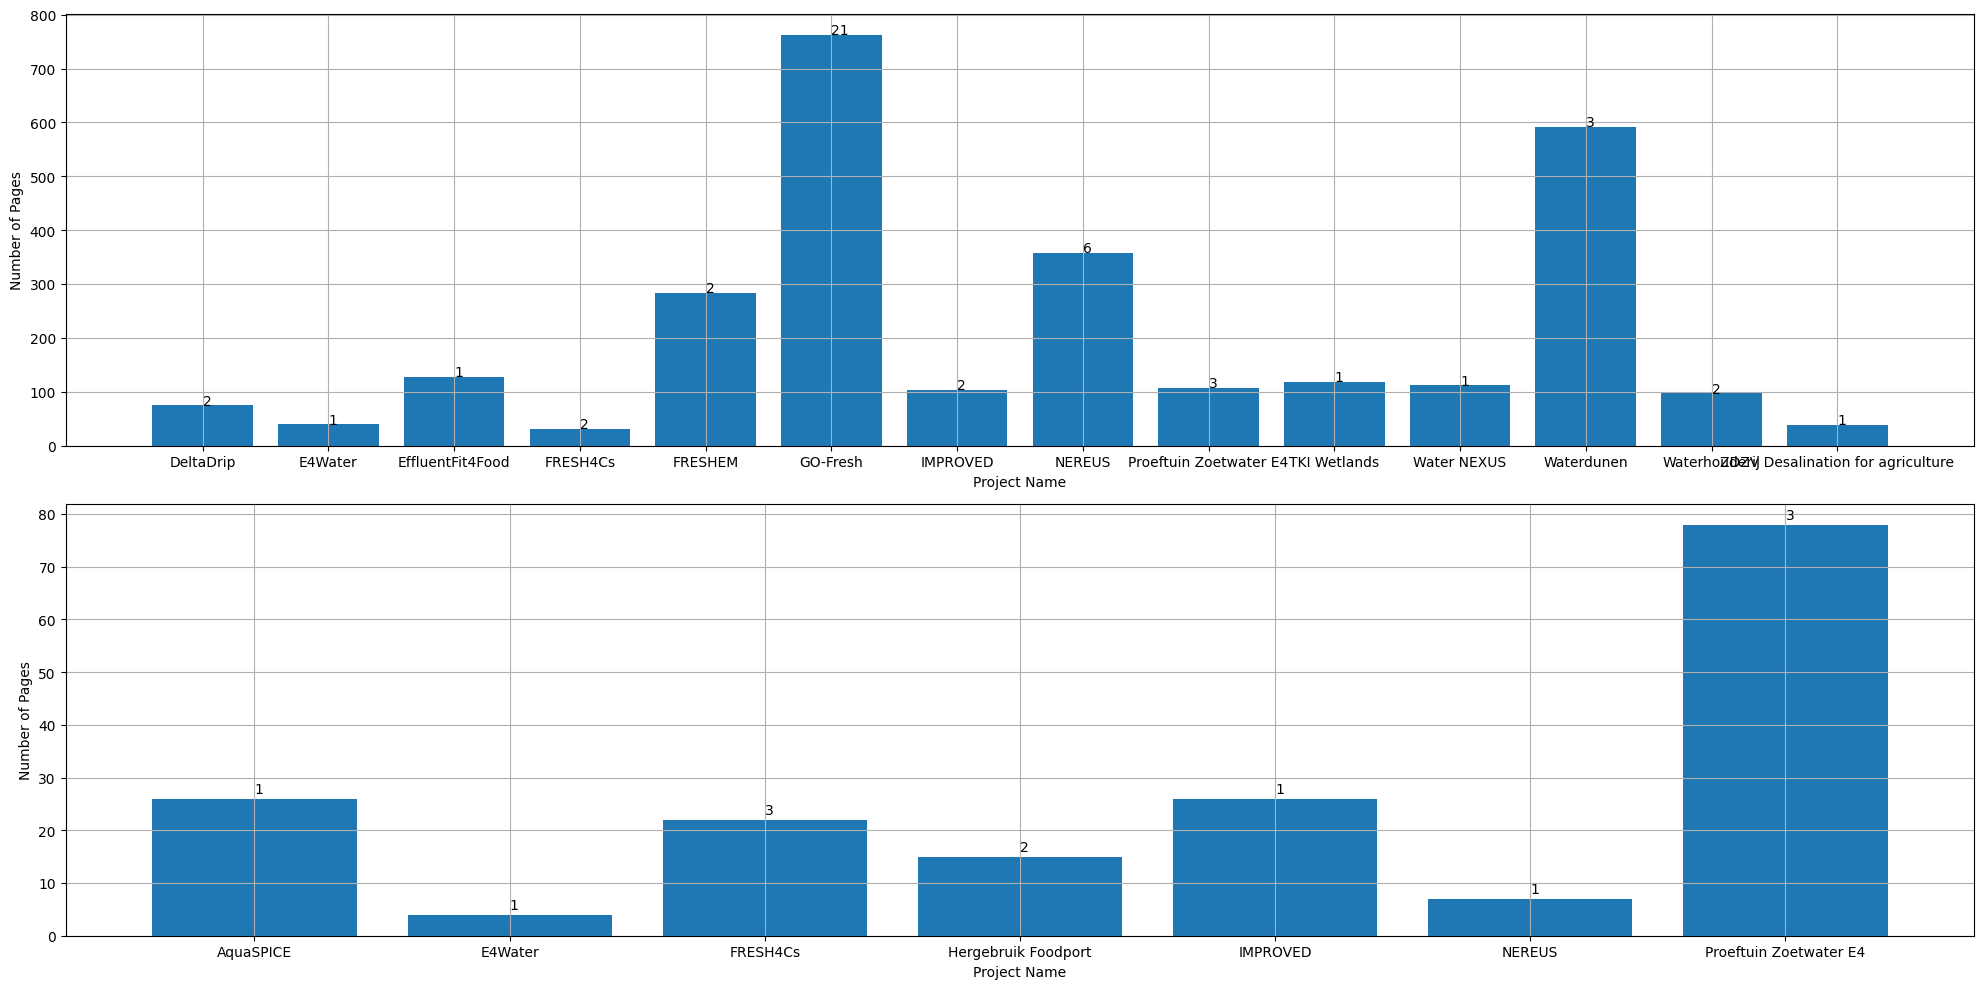

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))


pdf_files = complete_file_df[complete_file_df['extension'] == '.pdf']
grouped_pdf = pdf_files.groupby('project name').agg({'num_pages':'sum', 'extension':'count'})
axes[0].bar(grouped_pdf.index, grouped_pdf['num_pages'])
axes[0].set_xlabel('Project Name')
axes[0].set_ylabel('Number of Pages')
axes[0].grid()

for i, total in enumerate(grouped_pdf['extension']):
  axes[0].text(i, grouped_pdf['num_pages'].iloc[i] + 1, str(total))


docx_files = complete_file_df[complete_file_df['extension'] == '.docx']
grouped_docx = docx_files.groupby('project name').agg({'num_pages':'sum', 'extension':'count'})
axes[1].bar(grouped_docx.index, grouped_docx['num_pages'])
axes[1].set_xlabel('Project Name')
axes[1].set_ylabel('Number of Pages')
axes[1].grid()

for i, total in enumerate(grouped_docx['extension']):
  axes[1].text(i, grouped_docx['num_pages'].iloc[i] + 1, str(total))

plt.tight_layout()
plt.show()

## .txt file

interestingly enough, there is only 1 .txt file. This file doesn't contain any actual research, but it contains links to other resources:
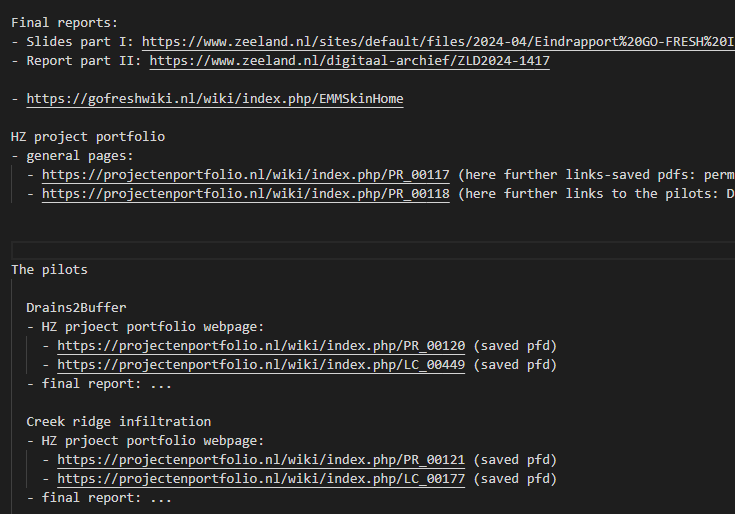

## .xlsx file

there seem to be just one xlsx, but as far as i can tell, they just show information about the projects we already have in the other directories. 
It might be worth it however to take a look at the links inside of here aswel

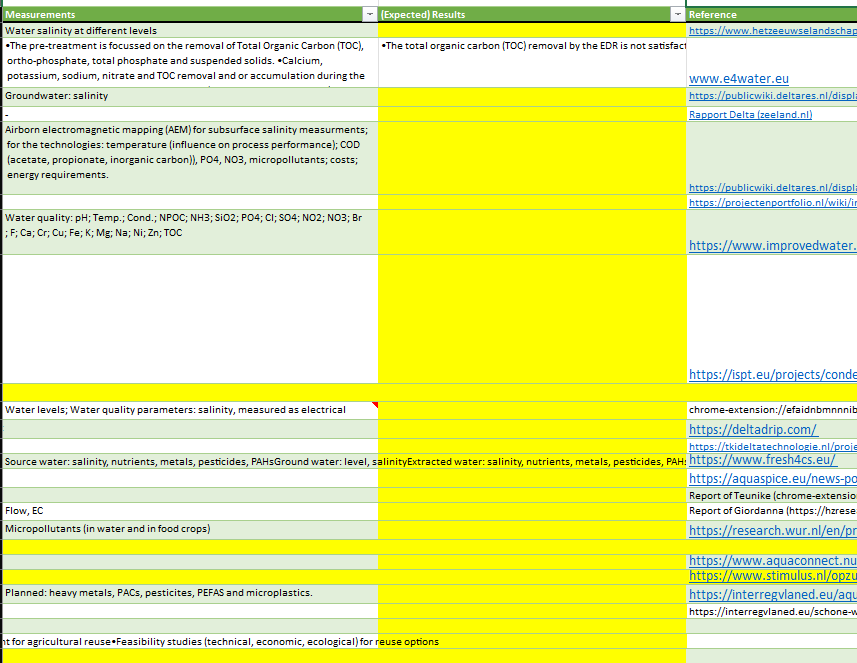